### **Przewidywanie gatunku muzycznego utworu**
Celem projektu jest przewidywanie gatunku muzycznego danego utworu udostępnionego w serwisie muzycznym Spotify na podstawie jego cech:
* *danceability* - jak odpowiedni jest utwór do tańca na podstawie kombinacji elementów muzycznych: tempo, stabilność rytmu, siła uderzenia oraz ogólna regularność; 0.0 - utwór najmniej taneczny; 1.0 - utwór najbardziej taneczny
* *energy* - reprezentacja intensywności i aktywności utworu; zazwyczaj utwory energiczne są szybkie i głośne; energia jest dobierana na podstawie dynamiczności utworu, głośności, barwy, częstotliwości początkowej oraz entropii ogólnej; 0.0 - utwór najmniej energiczny; 1.0 - utwór najbardziej energiczny
* *key* - notacja muzyczna na podstawie klasyfikacji Pitch: *https://en.wikipedia.org/wiki/Pitch_class*: 0 C do, 1 C♯, 2 D re, 3 D♯, 4 E mi, 5 F fa, 6 F♯, 7 sol, 8 G♯, 9 A la, 10 A♯, 11 B ti
* *loudness* - ogólna głośność utworu w dB; wartość jest uśredniona dla całego utworu; typowe wartości dla głośności to przedział: <-60, 0>
* *mode* - moda, czyli rodzaj skali z której pochodzi zawartość melodyczna utworu; 1 - major (większa skala); 0 - minor (mniejsza skala)
* *speechiness* - mowa w utworze; wartości między 1.0, a 0.66 oznaczają utwór wykonany prawdopodobnie z wypowiadanych słów; wartości między 0.66, a 0.33 to utwory, które prawdopodobnie zawierają muzykę oraz mowę; wartości między 0.33, a 0.0 najprawdopodobniej reprezentują tylko muzykę
* *acousticness* - pomiar akustyczności utworu (instrumenty wytwarzają dźwięk przy użyciu wibratora); 1.0 - duża akustyczność utworu, 0.0 - mała akustyczność utworu
* *instrumentalness* - przewidywanie, że utwór nie zawiera wokali; dźwięki *'Ooh'* oraz *'Aah'* są traktowane jako instrumentalne; im bliżej wartości 1.0 tym większe prawdopodobieństwo, że utwór nie zawiera treści wokalnych; wartości powyżej 0.5 reprezentują ścieżki instrumentalne (pozbawione wokalu)
* *liveness* - wykrywana obecność publiczności w nagraniu; wartości powyżej 0.8 zapewniają duże prawdopodobieństwo wykonania utworu na żywo
* *valence* - wartościowość pozytywna utworu; opisuje pozytywność muzyczną przenoszoną przez ścieżkę; 1.0 - utwory pozytywne (wesołe, szczęśliwe, euforyczne); 0.0 - utwory brzmiące negatywnie (smutne, przygnębiające, złe)
* *tempo* - ogólne szacowane tempo utworu w uderzeniach na minutę (bpm) - średni czas trwania rytmu
* *duration_ms* - długość utworu w ms

W realizacji projektu wykorzystywane są również zmienne:
* *total_followers* - łączna ilość użytkowników obserwujących danego artystę w serwisie Spotify
* *popularity* - popularność artysty w serwisie Spotify; w skali od: 0 - mała popularność artysty, do: 100 - duża popularność artysty
* *release_date* - data wydania albumu (a tym samym utworu przyporządkowanemy temu albumowi)	
* *total_tracks* - łączna ilość utworów na wydanym albumie
* *genre* - gatunek muzyczny przyporządkowany artyście (nadzorca)

Opis dostarczenia danych do projektu został uwzględniony w sekcji **Lista ID artystów**.

In [1]:
import spotipy
import spotipy.util as util
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore') # wyłączenie ostrzeżeń
%matplotlib inline # prezentacja wyresów w ramach komóki Jupyter Notebook

UsageError: unrecognized arguments: # prezentacja wyresów w ramach komóki Jupyter Notebook


### **Poświadczenia *Spotify for Developers***
Aby uzyskać dostęp do API Spotify niezbędne jest zalogowanie się w serwisie *https://developer.spotify.com/* poświadczeniami używanymi w aplikacji Spotify. Posiadanie konta Premium *https://www.spotify.com/pl/premium/* umożliwia korzystanie ze wszystkich bibliotek API. W serwisie zostają wygenerowane *CLIENT_ID* oraz *CLIENT_SECRET* niezbędne do wygenerowanie token'a autoryzacji zarówno z poziomu frontend'u serwisu oraz z poziomu kodu programu.

In [3]:
USERNAME = '11124576993'
CLIENT_ID = '0e46da03f45b4cd78495b0d520201a77'
CLIENT_SECRET = 'e7bb14e6f6a64547bcd60810ae334f6a'
REDIRECT_URL = 'http://localhost:8888'
# pełny zakres 'authorization scopes': https://developer.spotify.com/documentation/general/guides/scopes/
SCOPE = 'user-read-recently-played user-top-read user-library-modify user-library-read playlist-read-private playlist-modify-public playlist-modify-private playlist-read-collaborative user-read-email user-read-birthdate user-read-private user-read-playback-state user-modify-playback-state user-read-currently-playing app-remote-control streaming user-follow-read user-follow-modify'

Wygenerowanie token'a

In [4]:
token = util.prompt_for_user_token(USERNAME, SCOPE, CLIENT_ID, CLIENT_SECRET, REDIRECT_URL)
if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Token could not be generated.")

#### **Lista ID artystów**
Dane do projektu zostały dostarczone w oparciu o wybranie 10 najpopularniejszych gatunków muzycznych 2018 roku wg raportu **IFPI Music Consumer Insight 2018**: *https://ifpi.org/downloads/Music-Consumer-Insight-Report-2018.pdf*. Na podstawie listy gatunków muzycznych wybrano listę 100 najpopularniejszych artystów w 2019 roku, którzy reprezentują wymienione w zestawieniu gatunki muzyczne. Dla każdego gatunku muzycznego wybrano po 10 artystów.

In [5]:
lst = ['6qqNVTkY8uBg9cP3Jd7DAH', # Billie Eillish - pop
       '66CXWjxzNUsdJxJ2JdwvnR', # Ariana Grande - pop
       '6LuN9FCkKOj5PcnpouEgny', # Khalid - pop
       '7n2wHs1TKAczGzO7Dd2rGr', # Shawn Mendes - pop
       '1HY2Jd0NmPuamShAr6KMms', # Lady Gaga - pop
       '6EB8VE9f7Ut6NOgviN6gDW', # Dawid Podsiadło - pop
       '1Cs0zKBU1kc0i8ypK3B9ai', # BTS - pop
       '246dkjvS1zLTtiykXe5h60', # Post Malone - pop
       '6M2wZ9GZgrQXHCFfjv46we', # Dua Lipa - pop
       '6eUKZXaKkcviH0Ku9w2n3V', # Ed Sheeran - pop
       '1dfeR4HaWDbWqFHLkxsg1d', # Queen - rock
       '53XhwfbYqKCa1cC15pYq2q', # Imagine Dragons - rock
       '3YQKmKGau1PzlVlkL1iodx', # Twenty One Pilotes - rock
       '711MCceyCBcFnzjGY4Q7Un', # AC/DC - rock
       '20JZFwl6HVl6yg8a4H3ZqK', # Panic! At The Disco - rock
       '7Ln80lUS6He07XvHI8qqHH', # Arctic Monkeys - rock
       '1U1eSs7M2ENf09cDx4lavK', # Krzysztof Zalewski - rock
       '0k17h0D3J5VfsdmQ1iZtE9', # Pink Floyd - rock
       '3WrFJ7ztbogyGnTHbHJFl2', # The Beatles - rock
       '0L8ExT028jH3ddEcZwqJJ5', # Red Hot Chili Peppers - rock
       '2exkZbmNqMKnT8LRWuxWgy', # Moderat - electronic
       '540vIaP2JwjQb9dm3aArA4', # DJ Snake - electronic
       '6IZ4ctovY9dl7bgHClAvKJ', # LSD - electronic
       '1aQwKFn00nswXRDUDipm0K', # Gaulin - electronic
       '4tZwfgrHOc3mvqYlEYSvVi', # Daft Punk- electronic
       '4k1ELeJKT1ISyDv8JivPpB', # The Prodigy - electronic
       '3OsRAKCvk37zwYcnzRf5XF', # Moby - electronic
       '5ee4yhrWOxaxvL77BoVpVR', # Lucky Luke - electronic
       '6FXMGgJwohJLUSr5nVlf9X', # Massive Attack - electronic
       '1GhPHrq36VKCY3ucVaZCfo', # The Chemical Brothers - electronic
       '1hCkSJcXREhrodeIHQdav8', # Ramin Djawadi - soundtrack
       '0YC192cP3KPCRWx8zr8MfZ', # Hans Zimmer - soundtrack
       '2M4eNCvV3CJUswavkhAQg2', # James Newton Howard - soundtrack
       '3dRfiJ2650SZu6GbydcHNb', # Johh Williams - soundtrack
       '2VZNmg4vCnew4Pavo8zDdW', # Max Ritcher - soundtrack
       '71jzN72g8qWMCMkWC5p1Z0', # Alexandre Desplat - soundtrack
       '3TaTCYiv3QcamWjvRCcz6Q', # Gavin Greenaway - soundtrack
       '3PhL2Vdao2v8SS8AptuhAr', # James Horner - soundtrack
       '1nIUhcKHnK6iyumRyoV68C', # Ennio Morricone - soundtrack
       '2qvP9yerCZCS0U1gZU8wYp', # Two Steps from Hell - soundtrack
       '0Y5tJX1MQlPlqiwlOH1tJY', # Travis Scott - rap
       '15UsOTVnJzReFVN1VCnxy4', # XXXTENTACION - rap
       '5K4W6rqBFWDnAN6FQUkS6x', # Kanye West - rap
       '4kYSro6naA4h99UJvo89HB', # Cardi B - rap
       '3TVXtAsR1Inumwj472S9r4', # Drake - rap
       '2kCcBybjl3SAtIcwdWpUe3', # Lil Peep - rap
       '4MCBfE4596Uoi2O4DtmEMz', # Juice WRLD - rap
       '02kJSzxNuaWGqwubyUba0Z', # G-Eazy - rap
       '2YZyLoL8N0Wb9xBt1NhZWg', # Kendrick Lamar - rap
       '7jVv8c5Fj3E9VhNjxT4snq', # Lil Nas X - rap
       '2ysnwxxNtSgbb9t1m2Ur4j', # George Ezra - singer
       '2FXC3k01G6Gw61bmprjgqS', # Hozier - singer
       '0hEurMDQu99nJRq8pTxO14', # John Mayer - singer
       '1g0fXhQMHAxlRyIBkCbuE7', # Matt Simons - singer
       '7AzjETXRUKNRSJHMW9GIqd', # Nina Nesbitt - singer
       '6zFYqv1mOsgBRQbae3JJ9e', # Billy Joel - singer
       '5l8VQNuIg0turYE1VtM9zV', # Leonard Cohen - singer
       '3eqjTLE0HfPfh78zjh6TqT', # Bruce Springsteen - singer
       '74ASZWbe4lXaubB36ztrGX', # Bob Dylan - singer
       '4MXUO7sVCaFgFjoTI5ox5c', # Surfjan Stevens - singer
       '5aIqB5nVVvmFsvSdExz408', # Johann Sebastian Bach - classical
       '4NJhFmfw43RLBLjQvxDuRS', # Wolfgang Amadeus Mozart - classical
       '7y97mc3bZRFXzT2szRM4L4', # Frederic Chopin - classical
       '5yxyJsFanEAuwSM5kOuZKc', # London Symphony Orchestra - classical
       '6uRJnvQ3f8whVnmeoecv5Z', # Berliner Philharmoniker - classical
       '3EA9hVIzKfFiQI0Kikz2wo', # Andrea Bocelli - classical
       '003f4bk13c6Q3gAUXv7dGJ', # Wiener Philharmoniker - classical
       '2wOqMjp9TyABvtHdOSOTUS', # Ludwik van Beethoven - classical
       '3PfJE6ebCbCHeuqO4BfNeA', # London Philharmonic Orchestra - classical
       '5Dl3HXZjG6ZOWT5cV375lk', # Yo-Yo Ma - classical
       '5pKCCKE2ajJHZ9KAiaK11H', # Rihanna - R&B
       '1Xyo4u8uXC1ZmMpatF05PJ', # The Weekend - R&B
       '6vWDO969PvNqNYHIOW5v0m', # Beyonce - R&B
       '2feDdbD5araYcm6JhFHHw7', # Labrinth - R&B
       '0ZED1XzwlLHW4ZaG4lOT6m', # Julia Michaels - R&B
       '3WGpXCj9YhhfX11TToZcXP', # Troye Sivan - R&B
       '6S2OmqARrzebs0tKUEyXyp', # Demi Lovato - R&B
       '3KedxarmBCyFBevnqQHy3P', # Jessie Reyez - R&B
       '5CCwRZC6euC8Odo6y9X8jr', # Rita Ora - R&B
       '0X2BH1fck6amBIoJhDVmmJ', # Ellie Goulding - R&B
       '2vf4pRsEY6LpL5tKmqWb64', # Elderbrook - soul
       '0bzfPKdbXL5ezYW2z3UGQj', # Michael Kiwanuka - soul
       '4f9iBmdUOhQWeP7dcAn1pf', # Rag'n'Bone Man - soul
       '4dpARuHxo51G3z768sgnrY', # Adele - soul
       '6Q192DXotxtaysaqNPy5yR', # Amy Winehouse - soul
       '5y2Xq6xcjJb2jVM54GHK3t', # John Legen - soul
       '7nwUJBm0HE4ZxD3f5cy5ok', # Aretha Franklin - soul
       '7sfgqEdoeBTjd8lQsPT3Cy', # Emeli Sande - soul
       '5Mq7iqCWBzofK39FBqblNc', # Jessie Ware - soul
       '2U3FuHYvL3vhkbDAXm24Ep', # Dan Caplen - soul
       '6wWVKhxIU2cEi0K81v7HvP', # Rammstein - metal
       '6XyY86QOPPrYVGvF9ch6wz', # Linkin Park - metal
       '1S9WnjiTrLaqPCJ8gWSWWq', # Nocny Kochanek - metal
       '3o2dn2O0FCVsWDFSh8qxgG', # Sabaton - metal
       '5eAWCfyUhZtHHtBdNk56l1', # System Of A Down - metal
       '3TOqt5oJwL9BE2NG9MEwDa', # Disturbed - metal
       '3qm84nBOXUEQ2vnTfUTTFC', # Guns N' Roses - metal
       '05fG473iIaoy82BF1aGhL8', # Slipknot - metal
       '2xiIXseIJcq3nG7C8fHeBj', # Three Days Grace - metal
       '2ye2Wgw4gimLv2eAKyk1NB'] # Metallica - metal

Wygenerowanie słownika na podstawie funkcji z API SpotiPy: *artist()*
* klucz: artist_id
* wartość jako lista: followers, genres (lista po konwersji na łańcuch znaków), name, popularity
Lista gatunków w wartości słownika posłuży jako nadzorca.

In [38]:
result_lst_dict_value = []
dict_of_artsits_basic_info = {}

for idx, value in enumerate(lst):
    dict_of_artist_info = sp.artist(value)
    dict_of_artsits_basic_info[value] = ''
    for key, elem in dict_of_artist_info.items():
        if key == 'followers':
            for key_followers, value_followers in elem.items():
                if key_followers == 'total':
                    result_lst_dict_value.append(value_followers)     
        if key == 'genres':
            result_lst_dict_value.append(' '.join(elem))
        if key == 'name':
            result_lst_dict_value.append(elem)
        if key == 'popularity':
            result_lst_dict_value.append(elem)
            dict_of_artsits_basic_info[value] = result_lst_dict_value
            result_lst_dict_value = []
            
dict_of_artsits_basic_info

{'6qqNVTkY8uBg9cP3Jd7DAH': [8245457, 'electropop pop', 'Billie Eilish', 100],
 '66CXWjxzNUsdJxJ2JdwvnR': [29956460,
  'dance pop pop post-teen pop',
  'Ariana Grande',
  96],
 '6LuN9FCkKOj5PcnpouEgny': [6555769, 'pop', 'Khalid', 97],
 '7n2wHs1TKAczGzO7Dd2rGr': [16890929,
  'canadian pop dance pop pop post-teen pop viral pop',
  'Shawn Mendes',
  92],
 '1HY2Jd0NmPuamShAr6KMms': [7686649, 'dance pop pop', 'Lady Gaga', 91],
 '6EB8VE9f7Ut6NOgviN6gDW': [398097,
  'polish indie polish pop talent show',
  'Dawid Podsiadło',
  67],
 '1Cs0zKBU1kc0i8ypK3B9ai': [18742986, 'dance pop edm pop', 'David Guetta', 90],
 '246dkjvS1zLTtiykXe5h60': [14162042, 'pop rap', 'Post Malone', 96],
 '6M2wZ9GZgrQXHCFfjv46we': [11616547,
  'dance pop pop post-teen pop uk pop',
  'Dua Lipa',
  89],
 '6eUKZXaKkcviH0Ku9w2n3V': [44808955, 'pop uk pop', 'Ed Sheeran', 96]}

Wszystkie z funkcji API SpotiPy używanych w projekcie zwracają rozbudowane słowniki. Przykładowo funkcja *current_user_playlists()* zwraca strukturę:
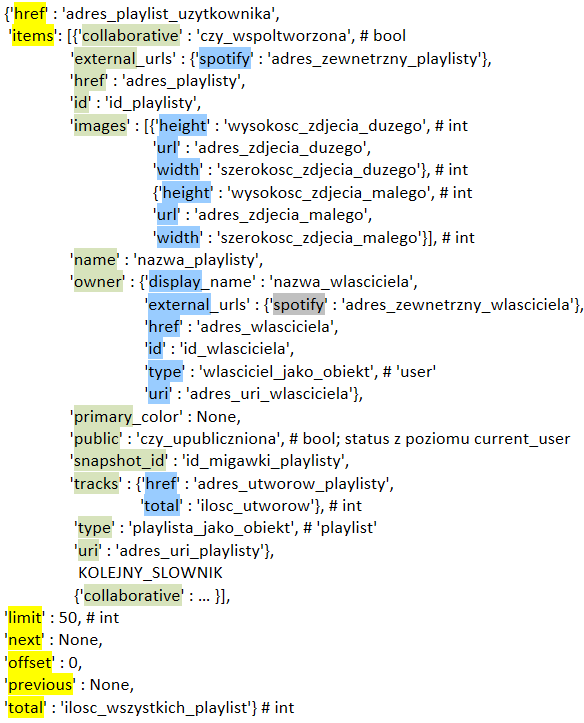

Utworzenie ramki DataFrame z podstawowymi informacjami o artyście. Liczba obserwujących, aktualna popularność artysty w serwisie to dane, które mogą zostać wykorzystane jako zmienne w modelu. Przyporządkowana lista gatunków posłuży jako nadzorca. Gatunek jest przyporządkowany przez serwis Spotify.

Na tym etapie należy stwierdzić, że lista gatunków wykroczy poza pierwotny wybór 10 najpopularniejszych. Przykładowy artysta powszechnie uchodzący za wykonawcę muzyki **pop** w serwisie Spotify jest charakteryzowany poprzez: **dance pop**, **pop** oraz **post-teen pop**.

In [39]:
df_artists_basic_info = pd.DataFrame(dict_of_artsits_basic_info).T
df_artists_basic_info.reset_index(level=0, inplace=True)
df_artists_basic_info.columns = ['artist_id', 'total_followers', 'genres', 'artist_name', 'popularity']
df_artists_basic_info.head(10)

,artist_id,total_followers,genres,artist_name,popularity
0,6qqNVTkY8uBg9cP3Jd7DAH,8245457,electropop pop,Billie Eilish,100
1,66CXWjxzNUsdJxJ2JdwvnR,29956460,dance pop pop post-teen pop,Ariana Grande,96
2,6LuN9FCkKOj5PcnpouEgny,6555769,pop,Khalid,97
3,7n2wHs1TKAczGzO7Dd2rGr,16890929,canadian pop dance pop pop post-teen pop viral...,Shawn Mendes,92
4,1HY2Jd0NmPuamShAr6KMms,7686649,dance pop pop,Lady Gaga,91
5,6EB8VE9f7Ut6NOgviN6gDW,398097,polish indie polish pop talent show,Dawid Podsiadło,67
6,1Cs0zKBU1kc0i8ypK3B9ai,18742986,dance pop edm pop,David Guetta,90
7,246dkjvS1zLTtiykXe5h60,14162042,pop rap,Post Malone,96
8,6M2wZ9GZgrQXHCFfjv46we,11616547,dance pop pop post-teen pop uk pop,Dua Lipa,89
9,6eUKZXaKkcviH0Ku9w2n3V,44808955,pop uk pop,Ed Sheeran,96


Aby uniknąć wzrostu liczby gatunków, które w gruncie rzeczy reprezentują ten sam gatunek nastąpiło ujednolicenie (w miarę możliwości) gatunków muzyczny, czyli np. przykładowy artysta powszechnie uchodzący za wykonawcę muzyki **pop** w serwisie Spotify charakteryzowany poprzez: **dance pop**, **pop** oraz **post-teen pop**, jest po transformacji wykonawcą muzyki: **pop**

In [40]:
df_artists_basic_info.loc[df_artists_basic_info['genres'].str.contains('metal'), 'genres'] = 'metal'
df_artists_basic_info.loc[df_artists_basic_info['genres'].str.contains('soul'), 'genres'] = 'soul'
df_artists_basic_info.loc[df_artists_basic_info['genres'].str.contains('r&b'), 'genres'] = 'r&b'
df_artists_basic_info.loc[df_artists_basic_info['genres'].str.contains('classical'), 'genres'] = 'classical'
df_artists_basic_info.loc[df_artists_basic_info['genres'].str.contains('singer'), 'genres'] = 'singer'
df_artists_basic_info.loc[df_artists_basic_info['genres'].str.contains('rap'), 'genres'] = 'rap'
df_artists_basic_info.loc[df_artists_basic_info['genres'].str.contains('soundtrack'), 'genres'] = 'soundtrack'
df_artists_basic_info.loc[df_artists_basic_info['genres'].str.contains('electronic'), 'genres'] = 'electronic'
df_artists_basic_info.loc[df_artists_basic_info['genres'].str.contains('rock'), 'genres'] = 'rock'
df_artists_basic_info.loc[df_artists_basic_info['genres'].str.contains('pop'), 'genres'] = 'pop'

Usuniecie zduplikowanych wartości, które powstały w wyniku powyższych przekształceń. Usunięcie również wierszy z artystami, którzy zostali sklasyfikowani jako artyści wykonujący mniej popularne gatunki.

In [41]:
df_artists_basic_info = df_artists_basic_info.drop_duplicates()
df_artists_basic_info[~df_artists_basic_info.genres.str.contains(' ')]
df_artists_basic_info.head(10)

,artist_id,total_followers,genres,artist_name,popularity
0,6qqNVTkY8uBg9cP3Jd7DAH,8245457,pop,Billie Eilish,100
1,66CXWjxzNUsdJxJ2JdwvnR,29956460,pop,Ariana Grande,96
2,6LuN9FCkKOj5PcnpouEgny,6555769,pop,Khalid,97
3,7n2wHs1TKAczGzO7Dd2rGr,16890929,pop,Shawn Mendes,92
4,1HY2Jd0NmPuamShAr6KMms,7686649,pop,Lady Gaga,91
5,6EB8VE9f7Ut6NOgviN6gDW,398097,pop,Dawid Podsiadło,67
6,1Cs0zKBU1kc0i8ypK3B9ai,18742986,pop,David Guetta,90
7,246dkjvS1zLTtiykXe5h60,14162042,rap,Post Malone,96
8,6M2wZ9GZgrQXHCFfjv46we,11616547,pop,Dua Lipa,89
9,6eUKZXaKkcviH0Ku9w2n3V,44808955,pop,Ed Sheeran,96


Funkcja zwracający DataFrame z przyporządkowanymi albumami (ID), datą wydania albumu i łączną ilością utworów na albumie dla wszystkich artystów, których ID jest przekazywane jako argument funkcji. Korzysta z funkcji API: *artist_albums()*.

In [42]:
def assign_albums_to_artist(lst):
    '''
    Returns a DataFrame with artist ID, album ID, release date of album and total tracks on album
    Parameters:
        - lst - list with any artist ID's
    '''
    dict_of_basic_artist_albums = {}
    dict_of_albums_info = {}
    list_of_albums = []
    list_of_album_info = []
    for idx_artist, value_artist in enumerate(lst):
        dict_of_artist_albums = sp.artist_albums(value_artist)
        dict_of_basic_artist_albums[value_artist] = ''
        for key_of_artist_albums_data, value_artist_albums_data in dict_of_artist_albums.items():
            if key_of_artist_albums_data == 'items':
                for idx_album, value_album in enumerate(value_artist_albums_data):
                    for key_album, item_album in value_album.items():
                        if key_album == 'id':
                            list_of_albums.append(item_album)
                            dict_of_basic_artist_albums[value_artist] = list_of_albums
                            key_track_id = item_album
                            dict_of_albums_info[key_track_id] = ''
                        if key_album == 'release_date':
                            list_of_album_info.append(item_album)
                        if key_album == 'total_tracks':
                            list_of_album_info.append(item_album)
                            dict_of_albums_info[key_track_id] = list_of_album_info
                            list_of_album_info = []
        list_of_albums = []
        
        df_dict_of_basic_artist_albums = pd.DataFrame([(key, value) for (key, L) in dict_of_basic_artist_albums.items() for value in L], 
        columns=['artist_id', 'album_id'])
        
        df_dict_of_albums_info = pd.DataFrame(dict_of_albums_info)
        df_dict_of_albums_info = df_dict_of_albums_info.T
        df_dict_of_albums_info.reset_index(level=0, inplace=True)
        df_dict_of_albums_info.columns = ['album_id', 'release_date', 'total_tracks']
        
        df_artist_albums = pd.merge(df_dict_of_basic_artist_albums, df_dict_of_albums_info, on='album_id')
    return df_artist_albums
df_artist_albums = assign_albums_to_artist(lst)
df_artist_albums.head(10)

,artist_id,album_id,release_date,total_tracks
0,6qqNVTkY8uBg9cP3Jd7DAH,0S0KGZnfBGSIssfF54WSJh,2019-03-29,14
1,6qqNVTkY8uBg9cP3Jd7DAH,0LgnntyagLdfW5Dz2OSYHU,2019-01-09,1
2,6qqNVTkY8uBg9cP3Jd7DAH,0ifM8RTX9HjtCJtY9452bW,2018-11-20,1
3,6qqNVTkY8uBg9cP3Jd7DAH,2sBB17RXTamvj7Ncps15AK,2018-04-19,1
4,6qqNVTkY8uBg9cP3Jd7DAH,1Z0XtKcevvITZ5ydimkYcx,2018-03-30,1
5,6qqNVTkY8uBg9cP3Jd7DAH,5m9lO9SriYMPpXTrVIU8P5,2018-03-09,1
6,6qqNVTkY8uBg9cP3Jd7DAH,5XRJoC2QtsNbAubsCrBBbG,2018-01-12,1
7,6qqNVTkY8uBg9cP3Jd7DAH,7fRrTyKvE4Skh93v97gtcU,2017-12-22,9
8,6qqNVTkY8uBg9cP3Jd7DAH,6eQpKhYCtvD0TwXQVHsgC2,2017-12-15,1
9,6qqNVTkY8uBg9cP3Jd7DAH,5YCdlD3eREt72lTZxNL7id,2017-08-11,11


Funkcja zwracający DataFrame z przyporządkowanymi utworami (ID) do albumów, których ID jest przekazywane jako argument funkcji. Korzysta z funkcji API: *album_tracks()*.

In [43]:
def assign_tracks_to_album(df_artist_albums):
    '''
    Returns a DataFrame with album ID and track ID
    Parameters:
        - df_artist_albums - DataFrame generated based on the 'assign_albums_to_artist()' function
    '''
    dict_of_album_tracks = {}
    list_of_track_id = []
    for index, row in assign_albums_to_artist(lst).iterrows():
        dict_with_album_tracks = sp.album_tracks(row['album_id'])
        dict_of_album_tracks[row['album_id']] = ''
        for key_of_album_tracks_data, value_album_tracks_data in dict_with_album_tracks.items():
            if key_of_album_tracks_data == 'items':
                for idx_track, value_track in enumerate(value_album_tracks_data):
                    for key_track, item_track in value_track.items():
                        if key_track == 'id':
                            list_of_track_id.append(item_track)
                dict_of_album_tracks[row['album_id']] = list_of_track_id
                list_of_track_id = []

    df_dict_of_album_tracks = pd.DataFrame([(key, value) for (key, L) in dict_of_album_tracks.items() for value in L], 
    columns=['album_id', 'track_id'])
    return df_dict_of_album_tracks
df_dict_of_album_tracks = assign_tracks_to_album(df_artist_albums)
df_dict_of_album_tracks.head(10)

,album_id,track_id
0,0S0KGZnfBGSIssfF54WSJh,0rQtoQXQfwpDW0c7Fw1NeM
1,0S0KGZnfBGSIssfF54WSJh,2Fxmhks0bxGSBdJ92vM42m
2,0S0KGZnfBGSIssfF54WSJh,4QIo4oxwzzafcBWkKjDpXY
3,0S0KGZnfBGSIssfF54WSJh,3XF5xLJHOQQRbWya6hBp7d
4,0S0KGZnfBGSIssfF54WSJh,6IRdLKIyS4p7XNiP8r6rsx
5,0S0KGZnfBGSIssfF54WSJh,3Fj47GNK2kUF0uaEDgXLaD
6,0S0KGZnfBGSIssfF54WSJh,43zdsphuZLzwA9k4DJhU0I
7,0S0KGZnfBGSIssfF54WSJh,6X29iaaazwho3ab7GNue5r
8,0S0KGZnfBGSIssfF54WSJh,3Tc57t9l2O8FwQZtQOvPXK
9,0S0KGZnfBGSIssfF54WSJh,4SSnFejRGlZikf02HLewEF


In [44]:
df_artist_album_track = pd.merge(df_artist_albums, df_dict_of_album_tracks, on='album_id')

Funkcja zwracający DataFrame z przyporządkowanymi cechami utworu: *danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms*. Kluczem jest ID utworu również ujęte w DataFrame. Korzysta z funkcji API: *audio_features()*.

In [45]:
def assign_track_details(df_dict_of_album_tracks):
    lst_track_info = []
    lst_item_track_info = []
    for idx, row in df_dict_of_album_tracks.iterrows():
        lst = sp.audio_features(row['track_id'])
        dict_track_info = lst[0]
        if dict_track_info == None:
            break
        lst_item_track_info.append(row['track_id'])
        for key, item in dict_track_info.items():
            if key == 'danceability':
                lst_item_track_info.append(item)
            if key == 'energy':
                lst_item_track_info.append(item)
            if key == 'key':
                lst_item_track_info.append(item)
            if key == 'loudness':
                lst_item_track_info.append(item)
            if key == 'mode':
                lst_item_track_info.append(item)
            if key == 'speechiness':
                lst_item_track_info.append(item)
            if key == 'acousticness':
                lst_item_track_info.append(item)
            if key == 'instrumentalness':
                lst_item_track_info.append(item)
            if key == 'liveness':
                lst_item_track_info.append(item)    
            if key == 'valence':
                lst_item_track_info.append(item)
            if key == 'tempo':
                lst_item_track_info.append(item)
            if key == 'duration_ms':
                lst_item_track_info.append(item)
                lst_track_info.append(lst_item_track_info)
                lst_item_track_info = []     
        df_track_info = pd.DataFrame(lst_track_info)
        df_track_info.columns=['track_id', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
    return df_track_info
df_track_details = assign_track_details(df_dict_of_album_tracks)
df_track_details.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0rQtoQXQfwpDW0c7Fw1NeM,0.000,0.278,1,-21.630,1,0.000,0.768,0.00000,0.669,0.0000,0.000,13578
1,2Fxmhks0bxGSBdJ92vM42m,0.701,0.425,7,-10.965,1,0.375,0.328,0.13000,0.100,0.5620,135.128,194088
2,4QIo4oxwzzafcBWkKjDpXY,0.521,0.125,9,-17.832,1,0.239,0.751,0.00207,0.265,0.0528,111.554,243725
3,3XF5xLJHOQQRbWya6hBp7d,0.678,0.533,4,-10.485,1,0.186,0.462,0.21900,0.139,0.3230,150.455,180953
4,6IRdLKIyS4p7XNiP8r6rsx,0.726,0.444,8,-8.922,0,0.372,0.283,0.14300,0.177,0.5690,185.044,168840


In [46]:
df_artist_album_track_details = pd.merge(df_artist_album_track, df_track_details, on='track_id')
df_artist_album_track_details.head()

,artist_id,album_id,release_date,total_tracks,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6qqNVTkY8uBg9cP3Jd7DAH,0S0KGZnfBGSIssfF54WSJh,2019-03-29,14,0rQtoQXQfwpDW0c7Fw1NeM,0.000,0.278,1,-21.630,1,0.000,0.768,0.00000,0.669,0.0000,0.000,13578
1,6qqNVTkY8uBg9cP3Jd7DAH,0S0KGZnfBGSIssfF54WSJh,2019-03-29,14,2Fxmhks0bxGSBdJ92vM42m,0.701,0.425,7,-10.965,1,0.375,0.328,0.13000,0.100,0.5620,135.128,194088
2,6qqNVTkY8uBg9cP3Jd7DAH,0S0KGZnfBGSIssfF54WSJh,2019-03-29,14,4QIo4oxwzzafcBWkKjDpXY,0.521,0.125,9,-17.832,1,0.239,0.751,0.00207,0.265,0.0528,111.554,243725
3,6qqNVTkY8uBg9cP3Jd7DAH,0S0KGZnfBGSIssfF54WSJh,2019-03-29,14,3XF5xLJHOQQRbWya6hBp7d,0.678,0.533,4,-10.485,1,0.186,0.462,0.21900,0.139,0.3230,150.455,180953
4,6qqNVTkY8uBg9cP3Jd7DAH,0S0KGZnfBGSIssfF54WSJh,2019-03-29,14,6IRdLKIyS4p7XNiP8r6rsx,0.726,0.444,8,-8.922,0,0.372,0.283,0.14300,0.177,0.5690,185.044,168840


Ostatecznie złączenie wszystkich wygenerowanych DataFrame'ów oraz wypisanie kolumn finalnej struktury.

In [47]:
df = pd.merge(df_artist_album_track_details, df_artists_basic_info, on='artist_id')
df.columns

Index(['artist_id', 'album_id', 'release_date', 'total_tracks', 'track_id',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'total_followers', 'genres', 'artist_name',
       'popularity'],
      dtype='object')

Sprawdzenie rozmiaru danych oraz występowania wartości pustych w zbiorze.
Wygenerowany zbiór to ponad 22500 utworów przyporządkowanych 100 artystom.

In [54]:
df.shape

(22510, 21)

In [55]:
pd.isnull(df).sum()

artist_id           0
album_id            0
release_date        0
total_tracks        0
track_id            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
total_followers     0
genres              0
artist_name         0
popularity          0
dtype: int64

Zliczenie każdej z populacji gatunków.

In [57]:
df_genre = pd.DataFrame(df.groupby('genres').size())
df_genre.reset_index(level=0, inplace=True)
df_genre.columns = ['genre', 'amount']
df_genre.sort_values('amount', ascending=False)

,genre,amount
9,soundtrack,3961
2,metal,3022
0,classical,2457
6,rock,2393
7,singer,2254
1,electronic,2151
4,r&b,2051
3,pop,1952
8,soul,1935
5,rap,334


Poniżej przedstawienie histogramów oraz rozkładu gęstości każdej ze zmiennych. Największa różnorodność w ramach całego zbioru dotyczy: taneczności utworu, energii, wokalu. W przypadku takich cech jak głośność oraz akustyczność najbardziej wyróżnionymi gatunkami są odpowiednio: muzyka klasyczna oraz muzyka metalowa.

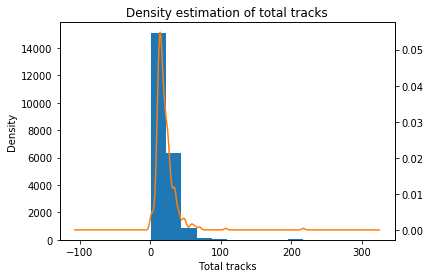

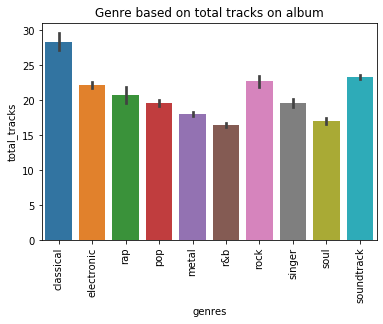

In [58]:
ax = df.total_tracks.plot(kind='hist')
df.total_tracks.plot(kind='kde', secondary_y=True)
ax.set_xlabel('Total tracks')
plt.title('Density estimation of total tracks')
plt.show()

fig = sns.barplot(x='genres', y='total_tracks', data=df)
plt.xticks(rotation=90)
plt.title('Genre based on total tracks on album')
plt.show()

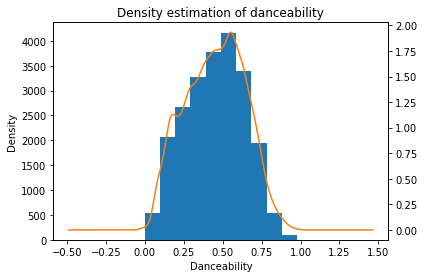

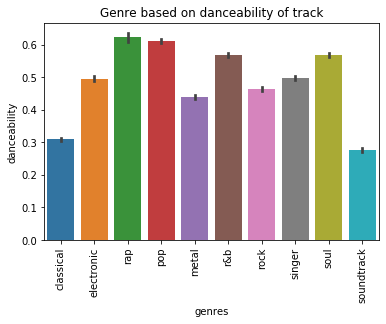

In [62]:
ax = df.danceability.plot(kind='hist')
df.danceability.plot(kind='kde', secondary_y=True)
ax.set_xlabel('Danceability')
plt.title('Density estimation of danceability')
plt.show()

fig = sns.barplot(x='genres', y='danceability', data=df)
plt.xticks(rotation=90)
plt.title('Genre based on danceability of track')
plt.show()

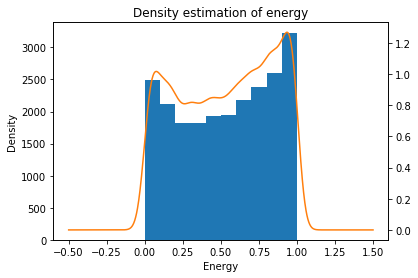

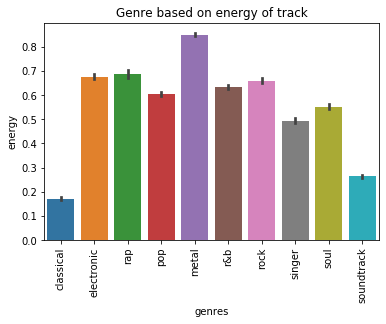

In [63]:
ax = df.energy.plot(kind='hist')
df.energy.plot(kind='kde', secondary_y=True)
ax.set_xlabel('Energy')
plt.title('Density estimation of energy')
plt.show()

fig = sns.barplot(x='genres', y='energy', data=df)
plt.xticks(rotation=90)
plt.title('Genre based on energy of track')
plt.show()

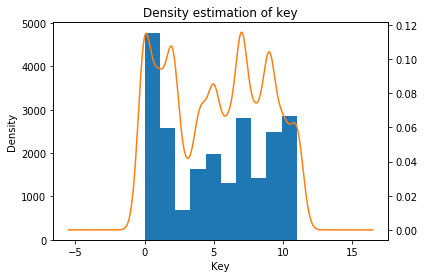

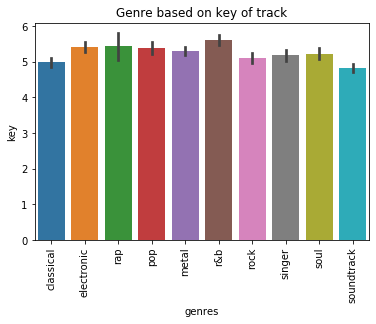

In [64]:
ax = df.key.plot(kind='hist')
df.key.plot(kind='kde', secondary_y=True)
ax.set_xlabel('Key')
plt.title('Density estimation of key')
plt.show()

fig = sns.barplot(x='genres', y='key', data=df)
plt.xticks(rotation=90)
plt.title('Genre based on key of track')
plt.show()

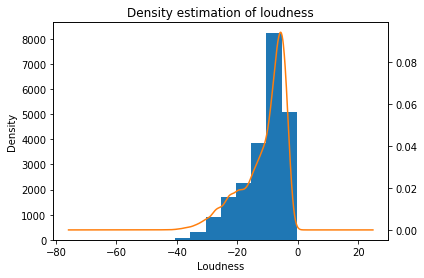

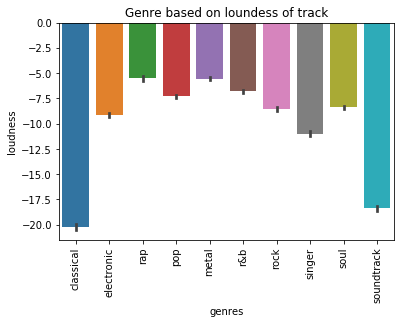

In [65]:
ax = df.loudness.plot(kind='hist')
df.loudness.plot(kind='kde', secondary_y=True)
ax.set_xlabel('Loudness')
plt.title('Density estimation of loudness')
plt.show()

fig = sns.barplot(x='genres', y='loudness', data=df)
plt.xticks(rotation=90)
plt.title('Genre based on loundess of track')
plt.show()

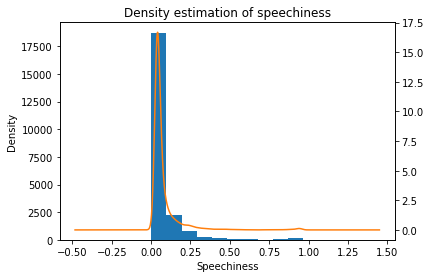

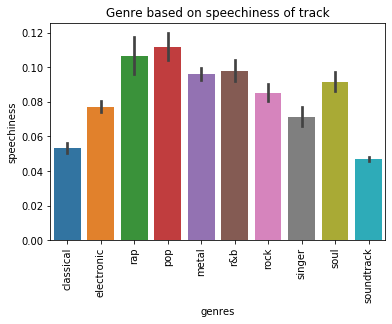

In [66]:
ax = df.speechiness.plot(kind='hist')
df.speechiness.plot(kind='kde', secondary_y=True)
ax.set_xlabel('Speechiness')
plt.title('Density estimation of speechiness')
plt.show()

fig = sns.barplot(x='genres', y='speechiness', data=df)
plt.xticks(rotation=90)
plt.title('Genre based on speechiness of track')
plt.show()

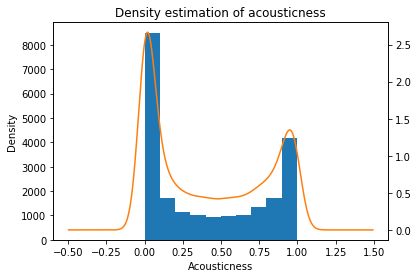

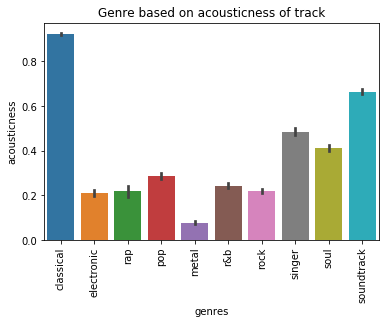

In [67]:
ax = df.acousticness.plot(kind='hist')
df.acousticness.plot(kind='kde', secondary_y=True)
ax.set_xlabel('Acousticness')
plt.title('Density estimation of acousticness')
plt.show()

fig = sns.barplot(x='genres', y='acousticness', data=df)
plt.xticks(rotation=90)
plt.title('Genre based on acousticness of track')
plt.show()

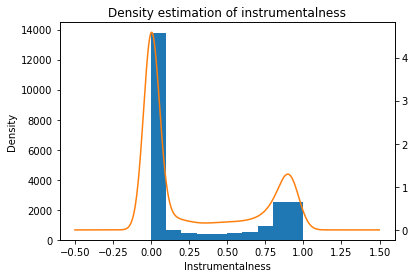

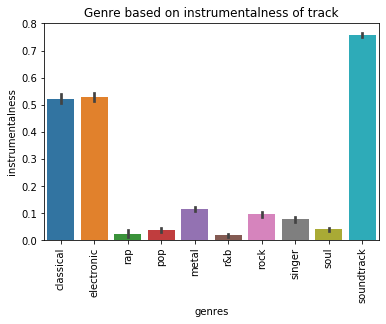

In [68]:
ax = df.instrumentalness.plot(kind='hist')
df.instrumentalness.plot(kind='kde', secondary_y=True)
ax.set_xlabel('Instrumentalness')
plt.title('Density estimation of instrumentalness')
plt.show()

fig = sns.barplot(x='genres', y='instrumentalness', data=df)
plt.xticks(rotation=90)
plt.title('Genre based on instrumentalness of track')
plt.show()

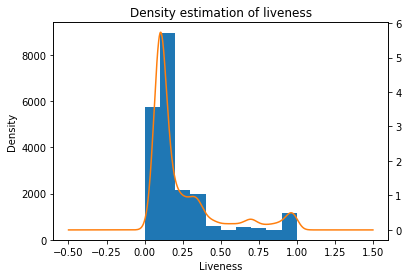

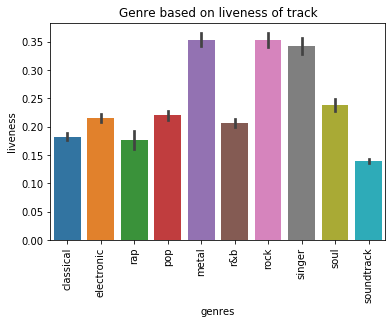

In [69]:
ax = df.liveness.plot(kind='hist')
df.liveness.plot(kind='kde', secondary_y=True)
ax.set_xlabel('Liveness')
plt.title('Density estimation of liveness')
plt.show()

fig = sns.barplot(x='genres', y='liveness', data=df)
plt.xticks(rotation=90)
plt.title('Genre based on liveness of track')
plt.show()

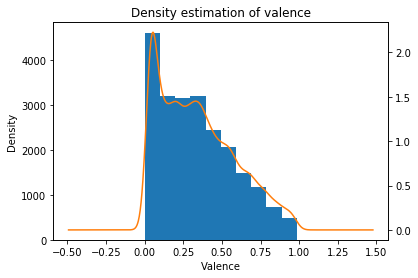

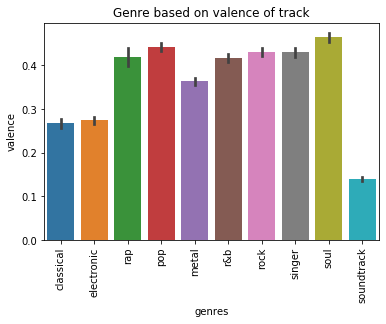

In [70]:
ax = df.valence.plot(kind='hist')
df.valence.plot(kind='kde', secondary_y=True)
ax.set_xlabel('Valence')
plt.title('Density estimation of valence')
plt.show()

fig = sns.barplot(x='genres', y='valence', data=df)
plt.xticks(rotation=90)
plt.title('Genre based on valence of track')
plt.show()

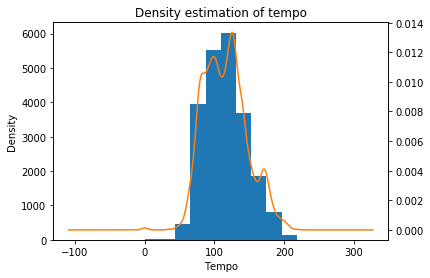

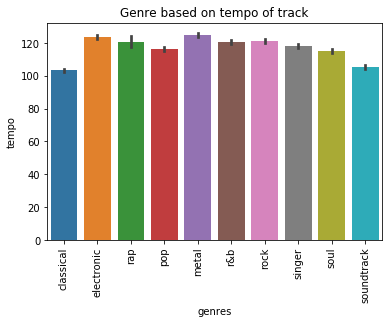

In [71]:
ax = df.tempo.plot(kind='hist')
df.tempo.plot(kind='kde', secondary_y=True)
ax.set_xlabel('Tempo')
plt.title('Density estimation of tempo')
plt.show()

fig = sns.barplot(x='genres', y='tempo', data=df)
plt.xticks(rotation=90)
plt.title('Genre based on tempo of track')
plt.show()

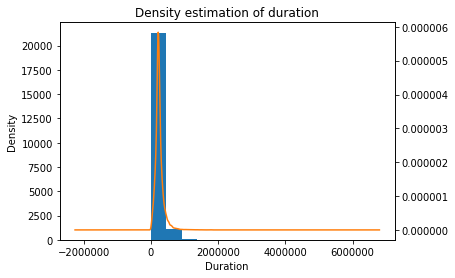

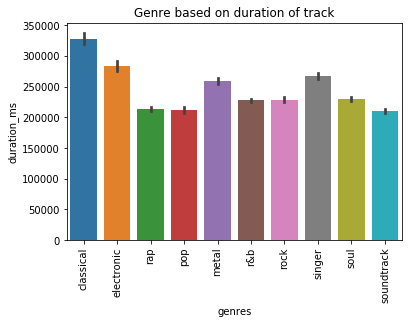

In [72]:
ax = df.duration_ms.plot(kind='hist')
df.duration_ms.plot(kind='kde', secondary_y=True)
ax.set_xlabel('Duration')
plt.title('Density estimation of duration')
plt.show()

fig = sns.barplot(x='genres', y='duration_ms', data=df)
plt.xticks(rotation=90)
plt.title('Genre based on duration of track')
plt.show()

Korelogram przedstawiający heatmap'ę zależności między każdą ze zmiennych. Na jego podstawie można stwierdzić, że najbardziej zależne są pary: *energy - loudness* oraz *popularity - total_followers*.
Najmniej zależne są pary zmiennych: *acousticness - energy* oraz *acousticness - loudness*.

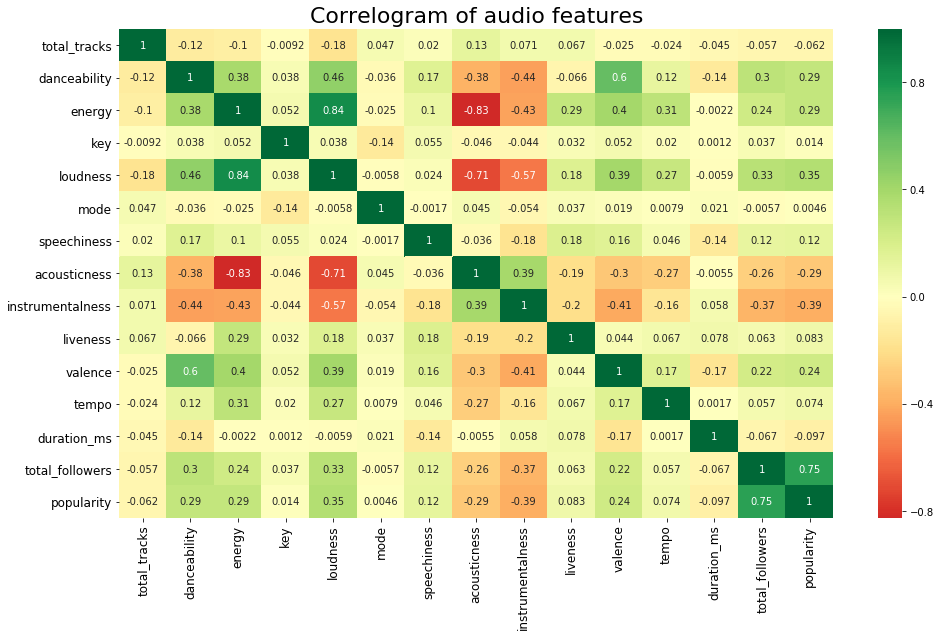

In [73]:
plt.rcParams['figure.figsize'] = [16,9]
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Correlogram of audio features', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Najbardziej rozproszona para zmiennych przedstawiona na wykresie *scatter: energy - acousticness*

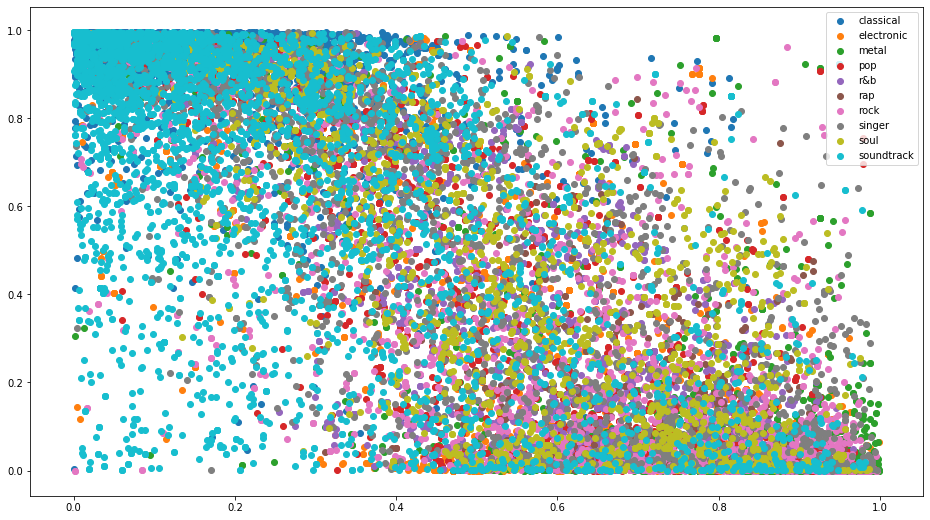

In [74]:
for index, row in df_genre.iterrows():
    genre_df = df[df['genres'] == row['genre']]
    plt.scatter(        
        genre_df['energy'],        
        genre_df['acousticness']
    )
    
plt.legend(df_genre['genre'])

Najmniej rozproszona para zmiennych przedstawiona na wykresie *scatter: loudness - energy*

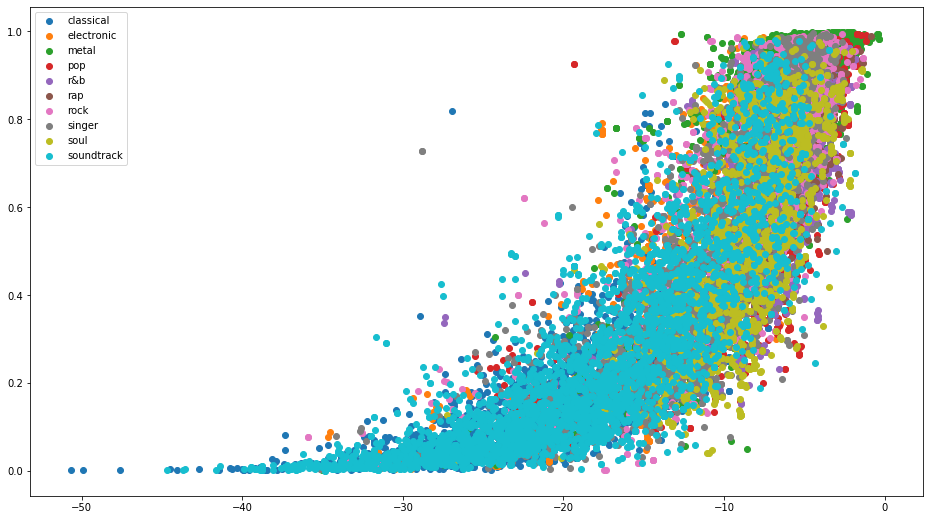

In [251]:
for index, row in df_genre.iterrows():
    genre_df = df[df['genres'] == row['genre']]
    plt.scatter(        
        genre_df['loudness'],        
        genre_df['energy']
    )
    
plt.legend(df_genre['genre'])

In [7]:
df1 = pd.DataFrame(df)
df2 = pd.DataFrame(df)
df.columns

Index(['artist_id', 'album_id', 'release_date', 'total_tracks', 'track_id',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'total_followers', 'genres', 'artist_name',
       'popularity'],
      dtype='object')

Przygotowano dwa zbiory danych (w dwóch DataFrame): jeden z orygianlnym zbiorem kolumn, a drugi z wyłączeniem kolumn: *total_followers, popularity, total_tracks* oraz *duration_ms*.

In [8]:
columns1 = ['artist_id', 'album_id', 'release_date', 'track_id', 'artist_name']
df1.drop(columns1, inplace=True, axis=1) # DataFrame z domyślnym układem kolumn

columns2 = ['artist_id', 'album_id', 'release_date', 'track_id', 'artist_name',
           'total_followers', 'popularity', 'total_tracks', 'duration_ms']
df2.drop(columns2, inplace=True, axis=1) # DataFrame ze zoptymalizowanym układem kolumn

In [9]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    df1.drop('genres', axis=1), 
    df1['genres'], 
    test_size=0.3, 
    random_state=42)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df2.drop('genres', axis=1), 
    df2['genres'], 
    test_size=0.3, 
    random_state=42)

Regresja logistyczna

In [10]:
log_reg_mod1 = LogisticRegression()
log_reg_mod1.fit(X_train1, y_train1)
log_reg_pred1 = log_reg_mod1.predict(X_test1)
log_reg_acc1 = accuracy_score(y_test1, log_reg_pred1)
print('Accuracy Logistic Regression default: ' + str(log_reg_acc1))

log_reg_mod2 = LogisticRegression()
log_reg_mod2.fit(X_train2, y_train2)
log_reg_pred2 = log_reg_mod2.predict(X_test2)
log_reg_acc2 = accuracy_score(y_test2, log_reg_pred2)
print('Accuracy Logistic Regression optimized: ' + str(log_reg_acc2))

Accuracy Logistic Regression default: 0.325336887309344
Accuracy Logistic Regression optimized: 0.45831482304161114


Las losowy

In [11]:
rfc_mod1 = RandomForestClassifier()
rfc_mod1.fit(X_train1, y_train1)
rfc_pred1 = rfc_mod1.predict(X_test1)
rfc_acc1 = accuracy_score(y_test1, rfc_pred1)
print('Accuracy Random Forest Classifier Default: ' + str(rfc_acc1))

rfc_mod2 = RandomForestClassifier()
rfc_mod2.fit(X_train2, y_train2)
rfc_pred2 = rfc_mod2.predict(X_test2)
rfc_acc2 = accuracy_score(y_test2, rfc_pred2)
print('Accuracy Random Forest Classifier Optimized: ' + str(rfc_acc2))

Accuracy Random Forest Classifier Default: 0.9801569672738042
Accuracy Random Forest Classifier Optimized: 0.7473715385754479


K-najbliższych sąsiadów

In [12]:
knn_mod1 = KNeighborsClassifier()
knn_mod1.fit(X_train1, y_train1)
knn_pred1 = knn_mod1.predict(X_test1)
knn_acc1 = accuracy_score(y_test1, knn_pred1)
print('Accuracy K-Neighbors Classifier Default: ' + str(knn_acc1))

knn_mod2 = KNeighborsClassifier()
knn_mod2.fit(X_train2, y_train2)
knn_pred2 = knn_mod2.predict(X_test2)
knn_acc2 = accuracy_score(y_test2, knn_pred2)
print('Accuracy K-Neighbors Classifier Optimized: ' + str(knn_acc2))

Accuracy K-Neighbors Classifier Default: 0.9709758625795942
Accuracy K-Neighbors Classifier Optimized: 0.482007996446024


Podsumowanie wyników dokładności modeli

In [13]:
accuracy = pd.DataFrame({'Model': ['Logistic Regression', 
                                   'Random Forest Classifier', 
                                   'K-Neighbors Classifier'],
                                   'Accuracy Default': [log_reg_acc1,
                                                        rfc_acc1,
                                                        knn_acc1],
                                   'Accuracy Optimized': [log_reg_acc2,
                                                          rfc_acc2,
                                                          knn_acc2],})
accuracy

,Model,Accuracy Default,Accuracy Optimized
0,Logistic Regression,0.325337,0.458315
1,Random Forest Classifier,0.980157,0.747372
2,K-Neighbors Classifier,0.970976,0.482008


Analizując powyższe wyniki należy stwierdzić, że najlepsze wyniki zwraca model Random Forrest Classifier na oryginalnym zbiorze danych. Dokładność modelu to ponad 98%.
Biorąc pod uwagę dostępność zmiennych z poziomu API SpotiPy można wysnuć wniosek, że udostępnione zmienne pozwalają oszacować gatunek muzyczny na podstawie cech utworu.